**Assignment 2** 

This assignment requires you to implement image recognition methods. Please understand and use relevant libraries. You are expected to solve both questions.

**Data preparation and rules**

Please use the images of the MNIST hand-written digits recognition dataset. You may use torchvision.datasets library to obtain the images and splits. You should have 60,000 training images and 10,000 test images. Use test images only to evaluate your model performance.


In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split


In [2]:
from tensorflow.keras.datasets import mnist
import cv2
import numpy as np

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

def preprocess_images(images):
    images = images.astype('float32') / 255.0
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
print(train_images.shape)
print(test_images.shape)            

2024-03-09 20:38:10.968969: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 20:38:11.046752: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(60000, 28, 28)
(10000, 28, 28)


Q1: SIFT-BoVW-SVM [4 points]

1. [2 points] Implement the SIFT detector and descriptor. Compute cluster centers for the Bag-of-Visual-Words approach. Represent the images as histograms (of visual words) and train a linear SVM model for 10-way classification.
Note 1: You may want to use libraries such as cv2 (OpenCV) and sklearn (Sci-kit learn) for doing this question. https://scikit-learn.org/stable/modules/svm.html#multi-class-classification may be useful for the SVM.
Note 2: Seed random numbers for reproducibility (running the notebook again should give you the same results!).

In [ ]:
from tensorflow.keras.datasets import mnist
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix


(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

def preprocess_images(images):
    images = images.astype('float32') / 255.0
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

def calc_features(images, sift_params):
    sift = cv2.SIFT_create(**sift_params)
    features = []
    for img in images:
        img = np.uint8(img * 255)  # Convert back to OpenCV usable format
        _, des = sift.detectAndCompute(img, None)
        if des is not None:
            features.append(des)
    return np.vstack(features) if features else np.empty((0, 128))

def perform_kmeans(features, k):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, _, centers = cv2.kmeans(features, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    return centers


def bag_of_features(features, centers, k):
    vec = np.zeros((1, k), dtype=np.float32)
    for i in range(features.shape[0]):
        diff = np.linalg.norm(np.tile(features[i], (k, 1)) - centers, axis=1)
        idx = np.argmin(diff)
        vec[0, idx] += 1
    return vec

def train_and_evaluate(train_images, train_labels, test_images, test_labels, sift_params, k, svm_params):
    features = calc_features(train_images, sift_params)
    centers = perform_kmeans(features, k)
    
    def create_feature_vec(img):
        des = calc_features([img], sift_params)
        if des.size > 0:
            return bag_of_features(des, centers, k).flatten()
        else:
            return np.zeros((k,))

    train_vec = np.array([create_feature_vec(img) for img in train_images])
    test_vec = np.array([create_feature_vec(img) for img in test_images])
    
    clf = SVC(**svm_params)
    clf.fit(train_vec, train_labels)
    
    preds = clf.predict(test_vec)
    return accuracy_score(test_labels, preds), confusion_matrix(test_labels, preds)




In [1]:
from tensorflow.keras.datasets import mnist
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

def preprocess_images(images):
    images = images.astype('float32') / 255.0
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

def calc_features(images, thresh):
    sift = cv2.SIFT_create(thresh)
    features = []
    for img in images:
        img = np.uint8(img * 255)  # Convert back to OpenCV usable format
        _, des = sift.detectAndCompute(img, None)
        if des is not None:
            features.append(des)
    return np.vstack(features) if features else np.empty((0, 128))  # Assuming SIFT descriptors have a length of 128


def perform_kmeans(features, k):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, _, centers = cv2.kmeans(features, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    return centers

def bag_of_features(features, centers, k):
    vec = np.zeros((1, k), dtype=np.float32)
    for i in range(features.shape[0]):
        diff = np.linalg.norm(np.tile(features[i], (k, 1)) - centers, axis=1)
        idx = np.argmin(diff)
        vec[0, idx] += 1
    return vec

def train_and_evaluate(train_images, train_labels, test_images, test_labels, thresh, k):
    features = calc_features(train_images, thresh)
    centers = perform_kmeans(features, k)
    
    def create_feature_vec(img):
        des = calc_features([img], thresh)
        if des.size > 0:  # Changed from None check to size check
            return bag_of_features(des, centers, k).flatten()
        else:
            return np.zeros((k,))  # Return a zero vector if no features are detected

    # Convert training and testing images to feature vectors
    train_vec = np.array([create_feature_vec(img).flatten() for img in train_images])
    test_vec = np.array([create_feature_vec(img).flatten() for img in test_images])

    # Check the shape of the feature vectors
    assert train_vec.ndim == 2, "train_vec is not a 2D array"
    assert test_vec.ndim == 2, "test_vec is not a 2D array"

    # Train SVM
    clf = SVC(kernel='linear', probability=True)
    clf.fit(train_vec, train_labels)
    
    # Evaluate
    preds = clf.predict(test_vec)
    return accuracy_score(test_labels, preds), confusion_matrix(test_labels, preds)

thresh = 10  # SIFT feature threshold
k = 150  # Number of clusters for KMeans
accuracy, conf_mat = train_and_evaluate(train_images, train_labels, test_images, test_labels, thresh, k)

print(f'Accuracy: {accuracy*100:.2f}%')
print('Confusion Matrix:')
print(conf_mat)


2024-03-09 22:41:54.038653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 22:41:54.071597: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Accuracy: 74.06%
Confusion Matrix:
[[ 833    6   20    2    0   37   56    9   10    7]
 [   2 1109    5    0    3    0    2   11    1    2]
 [  50   27  632   28   29   30   29  159   33   15]
 [   9    9   66  767   18   82   13   22   14   10]
 [   1   16   35   14  771   18   19   29   28   51]
 [  57   15   19   63   19  575   61   46   13   24]
 [  64   21   36   15    6   53  560   57   17  129]
 [  11   76  109   11   29   21   31  733    6    1]
 [  21    3   36   24   33   20   38    6  746   47]
 [  16   11   14   14   43   38  136   21   36  680]]


2. [1 point] Keeping everything else constant, plot how classification accuracy changes as you sweep across 6 different values for the number of clusters. Please decide what numbers are meaningful for this question. Explain the trends in classification accuracy that you observe.
Note 1: It is recommended to try hyperparameters in logarithmic steps such as 2x or 3x multiples. An example of 2x multiples is: 1, 2, 5, 10, 20, ... An example of 3x multiples is: 1, 3, 10, 30, 100, ...


Evaluating for k = 10


Accuracy for k = 10: 42.17%
Evaluating for k = 30
Accuracy for k = 30: 57.41%
Evaluating for k = 100
Accuracy for k = 100: 70.80%
Evaluating for k = 300
Accuracy for k = 300: 79.23%


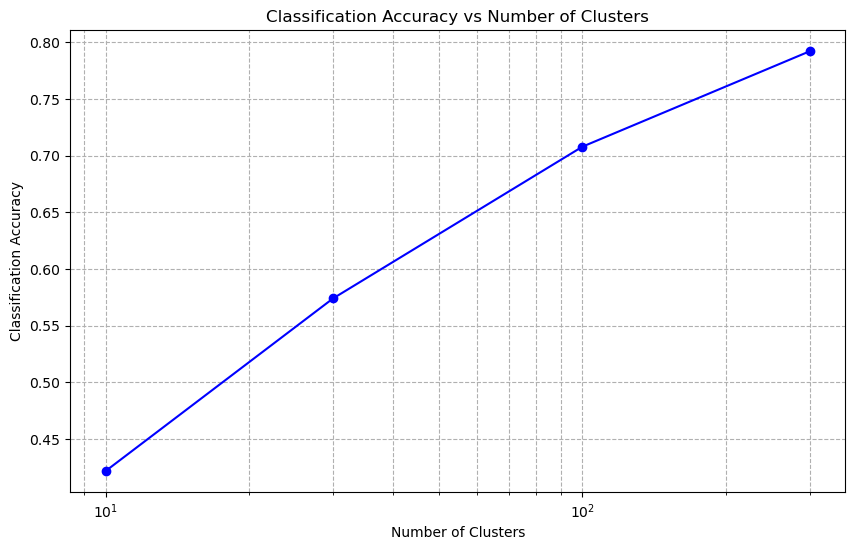

In [3]:
cluster_counts = [10, 30, 100, 300]
# cluster_counts = [10, 30, 100, 300, 1000, 3000]

accuracies = []

for k in cluster_counts:
    print(f"Evaluating for k = {k}")
    accuracy, _ = train_and_evaluate(train_images, train_labels, test_images, test_labels, thresh, k)
    accuracies.append(accuracy)
    print(f"Accuracy for k = {k}: {accuracy*100:.2f}%")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, accuracies, marker='o', linestyle='-', color='b')
plt.title("Classification Accuracy vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Classification Accuracy")
plt.xscale("log")  # Because we're using a logarithmic scale for cluster counts
plt.grid(True, which="both", ls="--")
plt.show()


3. [1 point] Show the results for 6 different hyperparameter settings. You may play with the SIFT detector or descriptor and the linear SVM. Keep the number of clusters constant based on the answer to the previous question. Explain the trends in classification accuracy that you observe.

In [3]:
sift_features = [{'nfeatures': 500}, {'nfeatures': 1000}, {'contrastThreshold': 0.04}, {'edgeThreshold': 10}]
svm_features = [{'kernel': 'linear', 'C': 1}, {'kernel': 'linear', 'C': 0.1}, {'kernel': 'rbf', 'C': 1, 'gamma': 'scale'}, {'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale'}]

k = 150  

for sift_params in sift_features:
    for svm_params in svm_features:
        accuracy, conf_mat = train_and_evaluate(train_images, train_labels, test_images, test_labels, sift_params, k, svm_params)
        print(f'SIFT Params: {sift_params}, SVM Params: {svm_params}, Accuracy: {accuracy*100:.2f}%')


SIFT Params: {'nfeatures': 500}, SVM Params: {'kernel': 'linear', 'C': 1}, Accuracy: 75.11%
SIFT Params: {'nfeatures': 500}, SVM Params: {'kernel': 'linear', 'C': 0.1}, Accuracy: 74.40%
SIFT Params: {'nfeatures': 500}, SVM Params: {'kernel': 'rbf', 'C': 1, 'gamma': 'scale'}, Accuracy: 78.46%
SIFT Params: {'nfeatures': 500}, SVM Params: {'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale'}, Accuracy: 74.28%
SIFT Params: {'nfeatures': 1000}, SVM Params: {'kernel': 'linear', 'C': 1}, Accuracy: 77.00%
SIFT Params: {'nfeatures': 1000}, SVM Params: {'kernel': 'linear', 'C': 0.1}, Accuracy: 76.71%
SIFT Params: {'nfeatures': 1000}, SVM Params: {'kernel': 'rbf', 'C': 1, 'gamma': 'scale'}, Accuracy: 77.80%
SIFT Params: {'nfeatures': 1000}, SVM Params: {'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale'}, Accuracy: 74.16%
SIFT Params: {'contrastThreshold': 0.04}, SVM Params: {'kernel': 'linear', 'C': 1}, Accuracy: 75.51%
SIFT Params: {'contrastThreshold': 0.04}, SVM Params: {'kernel': 'linear', 'C': 0.1}, Accur

| SIFT Params                   | SVM Params                               | Accuracy |
|-------------------------------|------------------------------------------|----------|
| `{'nfeatures': 500}`          | `{'kernel': 'linear', 'C': 1}`           | 75.11%   |
| `{'nfeatures': 500}`          | `{'kernel': 'linear', 'C': 0.1}`         | 74.40%   |
| `{'nfeatures': 500}`          | `{'kernel': 'rbf', 'C': 1, 'gamma': 'scale'}` | 78.46%   |
| `{'nfeatures': 500}`          | `{'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale'}` | 74.28%   |
| `{'nfeatures': 1000}`         | `{'kernel': 'linear', 'C': 1}`           | 77.00%   |
| `{'nfeatures': 1000}`         | `{'kernel': 'linear', 'C': 0.1}`         | 76.71%   |
| `{'nfeatures': 1000}`         | `{'kernel': 'rbf', 'C': 1, 'gamma': 'scale'}` | 77.80%   |
| `{'nfeatures': 1000}`         | `{'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale'}` | 74.16%   |
| `{'contrastThreshold': 0.04}` | `{'kernel': 'linear', 'C': 1}`           | 75.51%   |
| `{'contrastThreshold': 0.04}` | `{'kernel': 'linear', 'C': 0.1}`         | 75.36%   |
| `{'contrastThreshold': 0.04}` | `{'kernel': 'rbf', 'C': 1, 'gamma': 'scale'}` | 77.33%   |
| `{'contrastThreshold': 0.04}` | `{'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale'}` | 74.78%   |
| `{'edgeThreshold': 10}`       | `{'kernel': 'linear', 'C': 1}`           | 76.30%   |
| `{'edgeThreshold': 10}`       | `{'kernel': 'linear', 'C': 0.1}`         | 76.44%   |
| `{'edgeThreshold': 10}`       | `{'kernel': 'rbf', 'C': 1, 'gamma': 'scale'}` | 76.81%   |
| `{'edgeThreshold': 10}`       | `{'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale'}` | 75.57%   |


Problem:
Learning to use SIFT discriptors to perform image classification using Bag of Visual words representation andd SVM classifier. 

Challenges:
1. Creating a modular and vectorized pipeline
2. properly initialising the kmeeans algorithm
3. tuning parameters of the SVM

Learning
1. Image classification using manual method
2. How to tune parameters of manual methods to get the most optimal parameters

